<a href="https://colab.research.google.com/github/spazewalker/SpeechRecog-Opencv/blob/master/Jasper_encoder_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --content-disposition --quiet https://api.ngc.nvidia.com/v2/models/nvidia/jasper_pyt_onnx_fp16_amp/versions/20.10.0/zip -O jasper_pyt_onnx_fp16_amp_20.10.0.zip
!unzip -o ./jasper_pyt_onnx_fp16_amp_20.10.0.zip && rm jasper_pyt_onnx_fp16_amp_20.10.0.zip  >>/dev/null 2>&1
!unzip -o ./jasper_pyt_onnx_fp16_amp.zip && rm jasper_pyt_onnx_fp16_amp.zip  >>/dev/null 2>&1
!pip install onnx  >>/dev/null 2>&1

Archive:  ./jasper_pyt_onnx_fp16_amp_20.10.0.zip
  inflating: jasper_pyt_onnx_fp16_amp.zip  
Archive:  ./jasper_pyt_onnx_fp16_amp.zip
  inflating: decoder-ts-script/1/model.pt  
  inflating: feature-extractor-ts-trace/1/model.pt  
  inflating: jasper-onnx/1/model.onnx  


In [ ]:
# import json
# import sys
# import os
# import time
# import numpy as np
# import cv2
# import onnx
# import onnxruntime
# from onnx import numpy_helper
 

# data = np.random.randn(512,64,1).astype('float32')
# session = onnxruntime.InferenceSession('jasper_dynamic_input_float.onnx', None)
# input_name = session.get_inputs()[0].name
# output_name = session.get_outputs()[0].name
# print(input_name)
# print(output_name)
 
# result = session.run([output_name], {input_name: data})
# # prediction=int(np.argmax(np.array(result).squeeze(), axis=0))
# # print(prediction)
# result

In [ ]:
# result[0].shape

In [295]:
import math
import random
import numpy as np

import librosa
import torch
import torch.nn as nn

@torch.jit.script
def normalize_batch(x, seq_len, normalize_type: str):
    pass
    # if normalize_type == "per_feature":
    #     x_mean = np.zeros((seq_len.shape[0], x.shape[1]), dtype=x.dtype)
    #     x_std = np.zeros((seq_len.shape[0], x.shape[1]), dtype=x.dtype)
    #     for i in range(x.shape[0]):
    #         x_mean[i, :] = np.mean(x[i, :, :seq_len[i]],axis=1)
    #         x_std[i, :] = np.std(x[i, :, :seq_len[i]],axis=1)
    #     # make sure x_std is not zero
    #     x_std += 1e-5
    #     return (x - np.expand_dims(x_mean,2)) / np.expand_dims(x_std,2)
    # else:
    #     return x

def hann_window(win_size, periodic=False, dtype=np.float64):
    if periodic:
        win_size+=1
    return np.array([1/2*(1-np.cos(2*np.pi*i/(win_size-1),dtype=dtype)) for i in range(win_size)])



class FilterbankFeatures(nn.Module):
    
    def __init__(self, spec_augment=None, cutout_augment=None,
                 sample_rate=16000, window_size=0.02, window_stride=0.01,
                 window="hann", normalize="per_feature", n_fft=512,
                 preemph=0.97, n_filt=64, lowfreq=0, highfreq=None, log=True,
                 dither=1e-5, pad_align=8, pad_to_max_duration=False,
                 max_duration=float('inf'), frame_splicing=1):

        torch_windows = {
            'hann': hann_window,
            'none': None,
        }

        self.n_fft = n_fft or 2 ** np.ceil(math.log2(self.win_length)) 

        self.win_length = int(sample_rate * window_size) # frame size
        self.hop_length = int(sample_rate * window_stride)

        self.normalize = normalize
        self.log = log
        #TORCHSCRIPT: Check whether or not we need this
        self.dither = dither
        self.frame_splicing = frame_splicing
        self.n_filt = n_filt
        self.preemph = preemph
        highfreq = highfreq or sample_rate / 2
        window_fn = torch_windows.get(window, None)
        self.window_tensor = window_fn(self.win_length, periodic=False) if window_fn else None
        self.filterbanks = np.expand_dims(np.array(mel(sample_rate, self.n_fft, n_mels=n_filt, fmin=lowfreq, fmax=highfreq), dtype=torch.float),0)


    def calculate_features(self, x, seq_len):
        dtype = x.dtype

        seq_len = np.ceil(seq_len.to(dtype=np.float) / self.hop_length).to(
            dtype=np.int)

        # dither
        if self.dither > 0:
            x += self.dither * np.random.randn(*x.shape)
            # some changes above

        # do preemphasis
        if self.preemph is not None:
            x = np.concatenate(
                (np.expand_dims(x[:, 0],1), x[:, 1:] - self.preemph * x[:, :-1]), axis=1)
        
        # Short Time Fourier Transform
        x  = stft(x, n_fft=self.n_fft, hop_length=self.hop_length,
                          win_length=self.win_length,
                          window=np.array(self.window_tensor,dtype=np.float))

            # get power spectrum
        x = x**2+(-1)

        # dot with filterbank energies
        x = np.matmul(np.array(self.filterbanks,dtype=x.dtype), x)
        # TODO: use librosa code to get filterbanks

        # log features if required
        if self.log:
            x = np.log(x + 1e-20)

        # frame splicing if required
        if self.frame_splicing > 1:
            raise ValueError('Frame splicing not supported')

        # normalize if required
        x = normalize_batch(x, seq_len, normalize_type=self.normalize)

        # mask to zero any values beyond seq_len in batch,
        # pad to multiple of `pad_align` (for efficiency)
        max_len = x.size(-1)
        mask = np.arange(max_len, dtype=seq_len.dtype)
        mask = mask.expand(x.size(0), max_len) >= expand_dims(seq_len,1) # Something needs to be done here
        x = x.masked_fill(mask.unsqueeze(1), 0) # TODO
        x.dtype=dtype
        return x, seq_len

In [296]:
f = FilterbankFeatures()

In [ ]:
x=np.random.randn(256,2560)
len = torch.LongTensor(256)

# r = f.calculate_features(x=x,seq_len=len)

In [ ]:
r[0].shape,r[1].shape

(torch.Size([256, 64, 17]), torch.Size([256]))

In [ ]:
(x.shape)

(256, 2560)

In [78]:
import torch
w=torch.hann_window(320,periodic=False)

In [79]:
w

tensor([0.0000e+00, 9.6977e-05, 3.8791e-04, 8.7264e-04, 1.5510e-03, 2.4227e-03,
        3.4875e-03, 4.7449e-03, 6.1944e-03, 7.8355e-03, 9.6675e-03, 1.1690e-02,
        1.3901e-02, 1.6302e-02, 1.8890e-02, 2.1664e-02, 2.4624e-02, 2.7769e-02,
        3.1096e-02, 3.4606e-02, 3.8296e-02, 4.2165e-02, 4.6212e-02, 5.0435e-02,
        5.4833e-02, 5.9403e-02, 6.4144e-02, 6.9054e-02, 7.4131e-02, 7.9373e-02,
        8.4779e-02, 9.0346e-02, 9.6071e-02, 1.0195e-01, 1.0799e-01, 1.1418e-01,
        1.2052e-01, 1.2700e-01, 1.3363e-01, 1.4041e-01, 1.4732e-01, 1.5437e-01,
        1.6155e-01, 1.6886e-01, 1.7631e-01, 1.8388e-01, 1.9157e-01, 1.9938e-01,
        2.0730e-01, 2.1534e-01, 2.2350e-01, 2.3175e-01, 2.4012e-01, 2.4858e-01,
        2.5714e-01, 2.6580e-01, 2.7454e-01, 2.8338e-01, 2.9229e-01, 3.0129e-01,
        3.1037e-01, 3.1951e-01, 3.2873e-01, 3.3802e-01, 3.4737e-01, 3.5677e-01,
        3.6624e-01, 3.7575e-01, 3.8531e-01, 3.9492e-01, 4.0457e-01, 4.1425e-01,
        4.2397e-01, 4.3372e-01, 4.4349e-

In [76]:
import numpy as np
def hann_window(win_size, periodic=False, dtype=np.float64):
    if periodic:
        return np.array([1/2*(1-np.cos(2*np.pi*i/win_size,dtype=dtype)) for i in range(win_size)])
    else:
        return np.array([1/2*(1-np.cos(2*np.pi*i/(win_size-1),dtype=dtype)) for i in range(win_size)])

In [193]:
x=torch.randn(512)
o = torch.stft(x, n_fft=512, hop_length=160, win_length=320, window=w)

In [280]:
# Constraint stft block sizes to 256kb
MAX_MEM_BLOCK = 2 ** 8 * 2 ** 10

def pad_center(data, size, axis=-1, **kwargs):
    kwargs.setdefault("mode", "constant")

    n = data.shape[axis]

    lpad = int((size - n) // 2)

    lengths = [(0, 0)] * data.ndim
    lengths[axis] = (lpad, int(size - n - lpad))

    if lpad < 0:
        raise Exception(
            ("Target size ({:d}) must be " "at least input size ({:d})").format(size, n)
        )

    return np.pad(data, lengths, **kwargs)

def valid_audio(y, mono=True):
    if not isinstance(y, np.ndarray):
        raise Exception("Audio data must be of type numpy.ndarray")

    if not np.issubdtype(y.dtype, np.floating):
        raise Exception("Audio data must be floating-point")

    if mono and y.ndim != 1:
        raise Exception(
            "Invalid shape for monophonic audio: "
            "ndim={:d}, shape={}".format(y.ndim, y.shape)
        )

    elif y.ndim > 2 or y.ndim == 0:
        raise Exception(
            "Audio data must have shape (samples,) or (channels, samples). "
            "Received shape={}".format(y.shape)
        )

    elif y.ndim == 2 and y.shape[0] < 2:
        raise Exception(
            "Mono data must have shape (samples,). " "Received shape={}".format(y.shape)
        )

    if not np.isfinite(y).all():
        raise Exception("Audio buffer is not finite everywhere")

    return True

def frame(x, frame_length, hop_length, axis=-1):
    if not isinstance(x, np.ndarray):
        raise Exception(
            "Input must be of type numpy.ndarray, " "given type(x)={}".format(type(x))
        )

    if x.shape[axis] < frame_length:
        raise Exception(
            "Input is too short (n={:d})"
            " for frame_length={:d}".format(x.shape[axis], frame_length)
        )

    if hop_length < 1:
        raise Exception("Invalid hop_length: {:d}".format(hop_length))

    if axis == -1 and not x.flags["F_CONTIGUOUS"]:
        x = np.asfortranarray(x)
    elif axis == 0 and not x.flags["C_CONTIGUOUS"]:
        x = np.ascontiguousarray(x)

    n_frames = 1 + (x.shape[axis] - frame_length) // hop_length
    strides = np.asarray(x.strides)

    new_stride = np.prod(strides[strides > 0] // x.itemsize) * x.itemsize

    if axis == -1:
        shape = list(x.shape)[:-1] + [frame_length, n_frames]
        strides = list(strides) + [hop_length * new_stride]

    elif axis == 0:
        shape = [n_frames, frame_length] + list(x.shape)[1:]
        strides = [hop_length * new_stride] + list(strides)

    else:
        raise Exception("Frame axis={} must be either 0 or -1".format(axis))

    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

def dtype_r2c(d, default=np.complex64):
    mapping = {
        np.dtype(np.float32): np.complex64,
        np.dtype(np.float64): np.complex128,
        np.dtype(np.float): np.complex,
    }

    # If we're given a complex type already, return it
    dt = np.dtype(d)
    if dt.kind == "c":
        return dt

    # Otherwise, try to map the dtype.
    # If no match is found, return the default.
    return np.dtype(mapping.get(dt, default))

def stft(y, n_fft, hop_length=None, win_length=None, window=None, center=True, pad_mode='reflect', normalized=False, onesided=None, return_complex=None):
    # Y is a 2d or 3d array with (Batch, Audio) format. TODO: make it batched operation
    # By default, use the entire frame
    if win_length is None:
        win_length = n_fft

    # Set the default hop, if it's not already specified
    if hop_length is None:
        hop_length = int(win_length // 4)

    mono = False if y.ndim==3 else True

    batch = y.shape[0]

    fft_window = window

    # Pad the window out to n_fft size
    fft_window = pad_center(fft_window, n_fft)

    # Reshape so that the window can be broadcast
    # np.vstack(fft_window*batch)
    fft_window = fft_window.reshape((-1, 1))

    # Check audio is valid
    valid_audio(y,mono=mono)

    # Pad the time series so that frames are centered
    if center:
        if n_fft > y.shape[-1]:
            warnings.warn(
                "n_fft={} is too small for input signal of length={}".format(
                    n_fft, y.shape[-1]
                )
            )

        y = np.pad(y, int(n_fft // 2), mode=pad_mode)

    elif n_fft > y.shape[-1]:
        raise Exception(
            "n_fft={} is too large for input signal of length={}".format(
                n_fft, y.shape[-1]
            )
        )

    # Window the time series.
    y_frames = frame(y, frame_length=n_fft, hop_length=hop_length)
    # print(y_frames)

    dtype = dtype_r2c(y.dtype)

    # Pre-allocate the STFT matrix
    stft_matrix = np.empty(
        (int(1 + n_fft // 2), y_frames.shape[1]), dtype=dtype, order="F"
    )
    # print(stft_matrix.shape)

    # how many columns can we fit within MAX_MEM_BLOCK?
    n_columns = MAX_MEM_BLOCK // (stft_matrix.shape[0] * stft_matrix.itemsize)
    n_columns = max(n_columns, 1)

    for bl_s in range(0, stft_matrix.shape[1], n_columns):
        bl_t = min(bl_s + n_columns, stft_matrix.shape[1])

        stft_matrix[:, bl_s:bl_t] = np.fft.rfft(
            fft_window * y_frames[:, bl_s:bl_t], axis=0
        )
    return np.stack((stft_matrix.real,stft_matrix.imag),axis=-1)

In [281]:
o_prime=stft(np.array(x), n_fft=512, hop_length=160, win_length=320, window=np.array(w))

In [282]:
import pickle
# pickle file on drive
with open('sample_audio.pickle','rb') as f:
    audio=pickle.load(f)

In [283]:
audio[1],audio[0].shape

(22050, (1323000,))

In [284]:
temp=stft(audio[0], n_fft=512, hop_length=160, win_length=320, window=np.array(w))

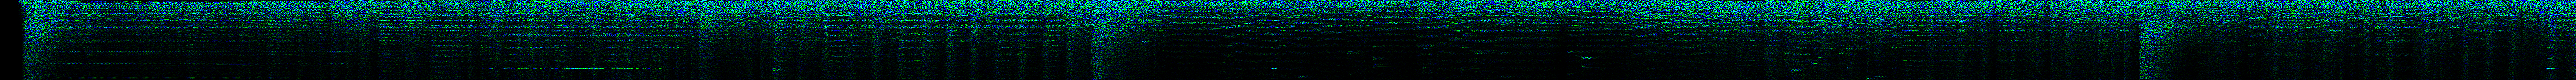

In [285]:
from google.colab.patches import cv2_imshow
cv2_imshow((np.stack((temp[:,:,0],temp[:,:,1],np.zeros(temp.shape[:-1])),axis=2)*255))
# 1st channel is realvalues after fft, 2nd is imaginary

In [ ]:
temp=torch.stft(torch.tensor(audio[0]), n_fft=512, hop_length=160, win_length=320, window=torch.tensor(w))

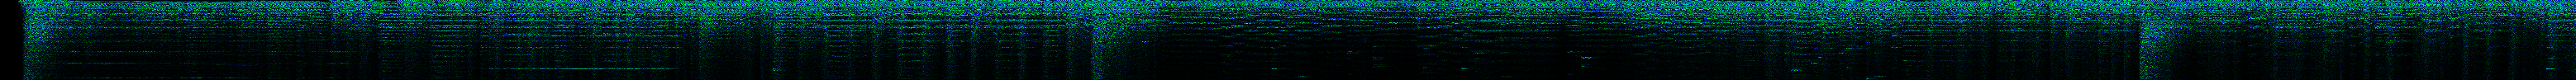

In [287]:
from google.colab.patches import cv2_imshow
    cv2_imshow((np.stack((temp[:,:,0],temp[:,:,1],np.zeros(temp.shape[:-1])),axis=2)*255))

In [301]:
librosa.filters.mel(16000, 512, n_mels=64, fmin=0, fmax=None).shape

(64, 257)

In [308]:
def normalize(S, norm=np.inf, axis=0, threshold=None, fill=None):
    # Avoid div-by-zero
    if threshold is None:
        threshold = tiny(S)

    elif threshold <= 0:
        raise ParameterError(
            "threshold={} must be strictly " "positive".format(threshold)
        )

    if fill not in [None, False, True]:
        raise ParameterError("fill={} must be None or boolean".format(fill))

    if not np.all(np.isfinite(S)):
        raise ParameterError("Input must be finite")

    # All norms only depend on magnitude, let's do that first
    mag = np.abs(S).astype(np.float)

    # For max/min norms, filling with 1 works
    fill_norm = 1

    if norm == np.inf:
        length = np.max(mag, axis=axis, keepdims=True)

    elif norm == -np.inf:
        length = np.min(mag, axis=axis, keepdims=True)

    elif norm == 0:
        if fill is True:
            raise ParameterError("Cannot normalize with norm=0 and fill=True")

        length = np.sum(mag > 0, axis=axis, keepdims=True, dtype=mag.dtype)

    elif np.issubdtype(type(norm), np.number) and norm > 0:
        length = np.sum(mag ** norm, axis=axis, keepdims=True) ** (1.0 / norm)

        if axis is None:
            fill_norm = mag.size ** (-1.0 / norm)
        else:
            fill_norm = mag.shape[axis] ** (-1.0 / norm)

    elif norm is None:
        return S

    else:
        raise ParameterError("Unsupported norm: {}".format(repr(norm)))

    # indices where norm is below the threshold
    small_idx = length < threshold

    Snorm = np.empty_like(S)
    if fill is None:
        # Leave small indices un-normalized
        length[small_idx] = 1.0
        Snorm[:] = S / length

    elif fill:
        # If we have a non-zero fill value, we locate those entries by
        # doing a nan-divide.
        # If S was finite, then length is finite (except for small positions)
        length[small_idx] = np.nan
        Snorm[:] = S / length
        Snorm[np.isnan(Snorm)] = fill_norm
    else:
        # Set small values to zero by doing an inf-divide.
        # This is safe (by IEEE-754) as long as S is finite.
        length[small_idx] = np.inf
        Snorm[:] = S / length

    return Snorm
# TODO Check above function

def hz_to_mel(frequencies, htk=False):
    frequencies = np.asanyarray(frequencies)

    if htk:
        return 2595.0 * np.log10(1.0 + frequencies / 700.0)

    # Fill in the linear part
    f_min = 0.0
    f_sp = 200.0 / 3

    mels = (frequencies - f_min) / f_sp

    # Fill in the log-scale part

    min_log_hz = 1000.0  # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp  # same (Mels)
    logstep = np.log(6.4) / 27.0  # step size for log region

    if frequencies.ndim:
        # If we have array data, vectorize
        log_t = frequencies >= min_log_hz
        mels[log_t] = min_log_mel + np.log(frequencies[log_t] / min_log_hz) / logstep
    elif frequencies >= min_log_hz:
        # If we have scalar data, heck directly
        mels = min_log_mel + np.log(frequencies / min_log_hz) / logstep

    return mels

def mel_to_hz(mels, htk=False):
    mels = np.asanyarray(mels)

    if htk:
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    # Fill in the linear scale
    f_min = 0.0
    f_sp = 200.0 / 3
    freqs = f_min + f_sp * mels

    # And now the nonlinear scale
    min_log_hz = 1000.0  # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp  # same (Mels)
    logstep = np.log(6.4) / 27.0  # step size for log region

    if mels.ndim:
        # If we have vector data, vectorize
        log_t = mels >= min_log_mel
        freqs[log_t] = min_log_hz * np.exp(logstep * (mels[log_t] - min_log_mel))
    elif mels >= min_log_mel:
        # If we have scalar data, check directly
        freqs = min_log_hz * np.exp(logstep * (mels - min_log_mel))

    return freqs

def mel_frequencies(n_mels=128, fmin=0.0, fmax=11025.0, htk=False):
    # 'Center freqs' of mel bands - uniformly spaced between limits
    min_mel = hz_to_mel(fmin, htk=htk)
    max_mel = hz_to_mel(fmax, htk=htk)

    mels = np.linspace(min_mel, max_mel, n_mels)

    return mel_to_hz(mels, htk=htk)

def fft_frequencies(sr=22050, n_fft=2048):
    return np.linspace(0, float(sr) / 2, int(1 + n_fft // 2), endpoint=True)

def mel(sr, n_fft, n_mels=128, fmin=0.0, fmax=None, htk=False, norm="slaney", dtype=np.float32):
    if fmax is None:
        fmax = float(sr) / 2

    # Initialize the weights
    n_mels = int(n_mels)
    weights = np.zeros((n_mels, int(1 + n_fft // 2)), dtype=dtype)

    # Center freqs of each FFT bin
    fftfreqs = fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of mel bands - uniformly spaced between limits
    mel_f = mel_frequencies(n_mels + 2, fmin=fmin, fmax=fmax, htk=htk)

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    if norm == "slaney":
        # Slaney-style mel is scaled to be approx constant energy per channel
        enorm = 2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])
        weights *= enorm[:, np.newaxis]
    else:
        weights = normalize(weights, norm=norm, axis=-1)

    # Only check weights if f_mel[0] is positive
    if not np.all((mel_f[:-2] == 0) | (weights.max(axis=1) > 0)):
        # This means we have an empty channel somewhere
        # warnings.warn(
        #     "Empty filters detected in mel frequency basis. "
        #     "Some channels will produce empty responses. "
        #     "Try increasing your sampling rate (and fmax) or "
        #     "reducing n_mels."
        # )

    return weights

In [307]:
mel_frequencies()

array([    0.        ,    26.19978713,    52.39957426,    78.59936139,
         104.79914851,   130.99893564,   157.19872277,   183.3985099 ,
         209.59829703,   235.79808416,   261.99787129,   288.19765842,
         314.39744554,   340.59723267,   366.7970198 ,   392.99680693,
         419.19659406,   445.39638119,   471.59616832,   497.79595545,
         523.99574257,   550.1955297 ,   576.39531683,   602.59510396,
         628.79489109,   654.99467822,   681.19446535,   707.39425247,
         733.5940396 ,   759.79382673,   785.99361386,   812.19340099,
         838.39318812,   864.59297525,   890.79276238,   916.9925495 ,
         943.19233663,   969.39212376,   995.59191089,  1022.72769586,
        1050.73771015,  1079.51485035,  1109.08012615,  1139.45512266,
        1170.66201615,  1202.72359026,  1235.6632526 ,  1269.50505185,
        1304.27369535,  1339.9945671 ,  1376.6937463 ,  1414.39802641,
        1453.13493468,  1492.93275229,  1533.82053494,  1575.82813412,
      